In [1]:
import numpy as np
import pandas as pd
from numpy import *
from numpy import split
from numpy import array
import geohash
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import fcluster
#from sklearn.preprocessing import StandardScalar
#from shapely.geometry import Point
#from shapely.geometry import MultiPoint
#from shapely.geometry.polygon import Polygon
import geopy
from geopy.geocoders import Nominatim, GoogleV3
from geopy.distance import great_circle
from math import radians, cos, sin, asin, sqrt
import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, InputLayer, Dense, Input, Flatten, concatenate, Reshape
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dense, Dropout, Permute
import functools
import itertools
import tensorflow as tf
#from utils import *
from keras import backend as K
import argparse
from keras import activations
from keras.engine.topology import Layer, InputSpec
from keras.utils import conv_utils
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras import metrics
from keras.layers.normalization import BatchNormalization
from random import randint
import pickle
import json

C:\Users\ubczh\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\ubczh\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.2.4
1.13.1


In [3]:
df1 = pd.read_csv('C://Users/ubczh/Downloads/traffic-management/Traffic Management/training.csv')
df1.describe()

,day,demand
count,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01
std,1.768278e+01,1.592655e-01
min,1.000000e+00,3.092217e-09
25%,1.600000e+01,1.867379e-02
50%,3.200000e+01,5.043463e-02
75%,4.700000e+01,1.208644e-01
max,6.100000e+01,1.000000e+00


In [4]:
# add 'fake' time index and lat,lon for future use
def convert_date(df):
    if df.day <= 30:
        return datetime.strptime('04-'+ str(df.day) + ',' + df.timestamp, '%m-%d,%H:%M')
    else: 
        return datetime.strptime('05-'+ str(df.day-30) + ',' + df.timestamp, '%m-%d,%H:%M')
    
df1['time'] = df1.apply(convert_date, axis = 1)
df1['lon'] = df1['geohash6'].apply(lambda x: round(geohash.decode_exactly(x)[1], 4))
df1['lat'] = df1['geohash6'].apply(lambda x: round(geohash.decode_exactly(x)[0], 4))
df1.head()

,geohash6,day,timestamp,demand,time,lon,lat
0,qp03wc,18,20:0,0.020072,1900-04-18 20:00:00,90.6537,-5.3531
1,qp03pn,10,14:30,0.024721,1900-04-10 14:30:00,90.6647,-5.4135
2,qp09sw,9,6:15,0.102821,1900-04-09 06:15:00,90.9064,-5.3256
3,qp0991,32,5:0,0.088755,1900-05-02 05:00:00,90.7526,-5.3531
4,qp090q,15,4:0,0.074468,1900-04-15 04:00:00,90.7196,-5.4135
5,qp03tu,1,12:15,0.023843,1900-04-01 12:15:00,90.6097,-5.3366
6,qp096d,25,3:30,0.007460,1900-04-25 03:30:00,90.8185,-5.3915
7,qp03nr,51,20:45,0.000293,1900-05-21 20:45:00,90.6317,-5.4080
8,qp093r,48,6:15,0.054170,1900-05-18 06:15:00,90.7635,-5.3641
9,qp03r2,4,22:15,0.123463,1900-04-04 22:15:00,90.6757,-5.4025


In [5]:
df2 = df1.copy()
df2 = df2.sort_values(by = ['time'])
df2.index = df2.time

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_percentage_error_ignore_zero(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true == 0] = np.nan
    #y_pred[y_pred == 0] = np.nan
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

In [7]:
# find days with missing timestamps(not for each zone)
df6 = df2.groupby('day', as_index=False).agg({
    'timestamp':'nunique',
    'demand':'count'
})
df6[df6.timestamp!=96]

,day,timestamp,demand
17,18,87,54871


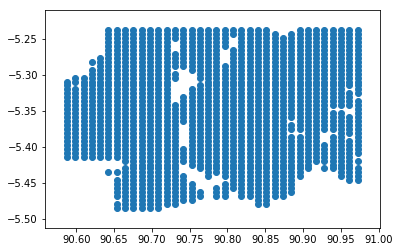

In [8]:
# plot out lat,lon points
df3 = df2.drop_duplicates(subset = ['lat','lon'])
plt.scatter(df3.lon, df3.lat)
plt.show()

In [9]:
# summarize zone demand for future use
df_desc_demand = pd.DataFrame(df2.groupby('geohash6', as_index=False).agg({
    'demand': [mean,std,min,max]  #'mean',
}))
df_desc_demand.columns = ['_'.join(x) for x in df_desc_demand.columns.ravel()]
df_desc_demand.rename(columns={'geohash6_':'geohash6'})
df_desc_demand.head()

,geohash6_,demand_mean,demand_std,demand_min,demand_max
0,qp02yc,0.022949,0.023054,1.108901e-05,0.263505
1,qp02yf,0.015384,0.016277,2.283778e-04,0.084991
2,qp02yu,0.022037,0.027530,2.570235e-03,0.041504
3,qp02yv,0.083860,0.078685,1.064920e-02,0.199402
4,qp02yy,0.019334,0.028808,1.004344e-03,0.222094
5,qp02yz,0.032254,0.035422,5.528258e-05,0.353148
6,qp02z1,0.040016,0.034847,9.956482e-07,0.212376
7,qp02z3,0.026052,0.028517,7.011257e-05,0.225302
8,qp02z4,0.021279,0.019845,1.365238e-05,0.156802
9,qp02z5,0.035216,0.032709,8.007160e-05,0.257526


In [10]:
# add missing timestamps for each zone
'''running takes about 20 mins'''
df35 = pd.DataFrame(data = np.zeros([len(pd.DatetimeIndex(df2.time.unique())), len(df2.geohash6.unique())]), 
                    columns = df2.geohash6.unique())
df35.index = pd.DatetimeIndex(df2.time.unique())

for geo in df2.geohash6.unique():
    df33 = df2[df2.geohash6 == geo] #.reset_index() #qp0928, 'qp08bm'
    #df33.index = df33.time
    for i in df33.index:
        df35.loc[i,geo] = df33.demand.loc[i]
    #df35.geo = df34.values
#df34.loc[[i for i in df33.index]] = df33.demand.loc[i]
#df35

,qp093f,qp03ys,qp095r,qp08cp,qp09dd,qp03mg,qp03py,qp03xg,qp03rp,qp097g,...,qp09v9,qp09m6,qp08g5,qp09nj,qp0d45,qp03yn,qp091j,qp09dy,qp02yu,qp092b
1900-04-01 00:00:00,0.010323,0.041485,0.019378,0.029288,0.144189,0.035749,0.007623,0.076038,0.006088,0.037533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 00:15:00,0.000000,0.068104,0.020458,0.080437,0.150009,0.021798,0.005554,0.093131,0.027763,0.030882,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 00:30:00,0.000000,0.071150,0.022692,0.106783,0.202354,0.033393,0.000000,0.093174,0.017994,0.043847,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 00:45:00,0.000000,0.077283,0.039953,0.030379,0.264491,0.043267,0.026071,0.114896,0.023719,0.028938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 01:00:00,0.000000,0.084419,0.061463,0.024383,0.281852,0.067285,0.015045,0.141920,0.023308,0.033308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 01:15:00,0.021024,0.087883,0.047777,0.073899,0.216191,0.092490,0.020873,0.089080,0.032736,0.089932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 01:30:00,0.000000,0.066802,0.052787,0.147764,0.207769,0.074190,0.014625,0.145115,0.018406,0.092124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 01:45:00,0.000000,0.104587,0.090059,0.112931,0.281120,0.109901,0.018580,0.145345,0.037075,0.111516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 02:00:00,0.000000,0.097331,0.097283,0.143088,0.257954,0.089674,0.007125,0.103525,0.050881,0.086841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-04-01 02:15:00,0.000000,0.118533,0.070478,0.178346,0.274582,0.105398,0.048341,0.160003,0.068851,0.057506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

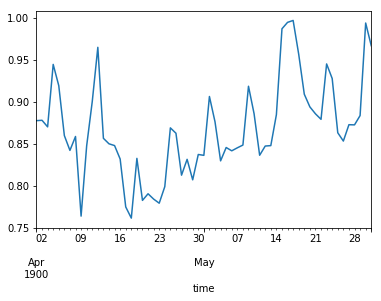

In [17]:
df16 = df2[(df2.lon == 90.8185) & (df2.lat == -5.3531)]
df16.index = df16.time
# daily demand
df16.resample('D').mean().demand.plot()
plt.show()

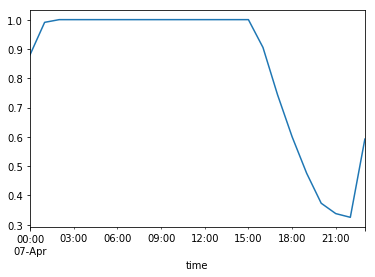

In [18]:
'''guess should be UTC time'''
# hourly demand in one day
df16[df16.day==7].resample('H').mean().demand.plot()
plt.show()

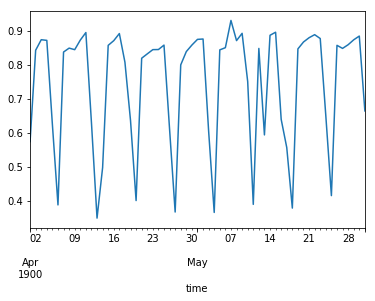

In [19]:
'''weekday weekend structure?'''
'''0-4 are weekdays, 5-6 are weekends'''
df10 = df2[(df2.lon == 90.6866) & (df2.lat == -5.3256)]
df10.index = df10.time
# daily demand
df10.resample('D').mean().demand.plot()
plt.show()

## model

### 2 types of models with different training speed and resolution: ‘one-node’ model and ‘multi-node’ model. 
### ‘one-node’ model uses the average demand of selected zones, and predicted a unified demand for all those zones; ‘multi-node’ model predicted demand for each selected zones in a model. ‘one-node’ model has faster training speed and lower accuracy, which is suitable for the many low-demand regions; ‘multi-node’ model on the other hand has lower training speed and higher accuracy, so it is suitable on the zones with higher demand.

### in the following code snippets, the cells with function 'horizon_node_lstm' are to train and validate model using data we can see; and the cells with function 'horizon_node_lstm_predict' are to predict on data we cannot see yet

In [12]:
'''train and validate models'''

def create_dataset_horizon1(dataset, look_back=1, horizon = 0):
    '''create multiple samples of timestamp sequences for training'''
    dataX, dataY = [], []
    for i in range(dataset.shape[0]-look_back-horizon-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back + horizon,:])
    return np.array(dataX), np.array(dataY)

def horizon_multi_node_lstm_1000(df, horizon, max_length=1, look_back=14, n_batch=4, n_epochs=30, num_time=1000, start=0):
    '''max_length: number of zones(features) to be predicted in model
       horizon: future timestamps to be predicted, T+1 means horizon=0, T+2 means horizon=1, etc..
       look_back: number of previous timestamps used to train in one sample
       num_time: length of timestamps used in the training data. according to the specified requirement, 
                 this cannot exceed 14*96 = 1344 
       start: the start timestamp of the training data
       start and num_time will determine the future timestamp to be predicted'''
    max_length = len(df.columns)
    tensor1 = df.values
    train_size = int(num_time*0.75) #0.25  
    test_size = int(num_time*0.25)  #0.08  
    # notice difference in shape here
    train, test = tensor1[start:(start+train_size),:], tensor1[(start+train_size):(start+train_size+test_size),:]
    print(train.shape, test.shape)
    np.random.seed(42)
    
    horizon = horizon
    trainX, trainY = create_dataset_horizon1(train, look_back, horizon)
    testX, testY = create_dataset_horizon1(test, look_back, horizon)
    testX_hz, testY_hz = create_dataset_horizon1(test, look_back, 0)
    print(trainX.shape, trainY.shape)
    
    trainX = np.reshape(trainX, (trainX.shape[0],max_length,look_back)) 
    testX = np.reshape(testX, (testX.shape[0],max_length,look_back))
    testX_hz = np.reshape(testX_hz, (testX_hz.shape[0],max_length,look_back))
    print(trainX.shape, testX.shape, testX_hz.shape)
    
    model = Sequential()
    model.add(LSTM(max_length, input_shape=(max_length,look_back)))
    model.add(Activation('relu'))
    #model.add(Dropout(0.4))
    #outputs = LSTM(units, return_sequences=True)(inputs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch, verbose=2, validation_data = (testX,testY))
    #history = model.fit(trainX, trainY, epochs, batch_size, verbose=2, validation_data = (testX,testY))
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    rmse_hz = np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+test_size+horizon-1):(start+train_size+test_size+horizon),
                                                i:i+1].values 
                                    - testPredict[-1][i])**2) for i in range(len(df.columns))]))
    
    print(np.sqrt(np.nanmean([np.nanmean((df.iloc[(start+train_size+look_back+horizon):(start+train_size+test_size-1),i:i+1].values 
                                          - testPredict[:,i:i+1])**2) for i in range(len(df.columns))])),
          np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+look_back+horizon):(start+train_size+test_size-1),i:i+1].values 
                                    - testPredict[:,i:i+1])**2) for i in range(len(df.columns))])))
    
    
    return model, history, trainPredict, testPredict, trainY, testY, rmse_hz

In [11]:
'''train and validate models'''

def create_dataset_horizon2(dataset, look_back=1, horizon = 0):
    dataX, dataY = [], []
    for i in range(dataset.shape[0]-look_back-horizon-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + horizon])
    return np.array(dataX), np.array(dataY)

def horizon_one_node_lstm_1000(array_demand, df, horizon, max_length=1, look_back=14, n_batch=4, n_epochs=30, num_time=1000,
                               start=0):
    tensor1 = array_demand.values
    train_size = int(num_time*0.75) 
    test_size = int(num_time*0.25) 
    # notice difference in shape here
    train, test = tensor1[0:train_size], tensor1[train_size:train_size+test_size]
    print(train.shape, test.shape)
    np.random.seed(42)
    
    horizon = horizon
    trainX, trainY = create_dataset_horizon2(train, look_back, horizon)
    testX, testY = create_dataset_horizon2(test, look_back, horizon)
    print(testX.shape, testY.shape)
    
    trainX = np.reshape(trainX, (trainX.shape[0],max_length,look_back)) 
    testX = np.reshape(testX, (testX.shape[0],max_length,look_back))
    print(trainX.shape, testX.shape)
    
    model = Sequential()
    model.add(LSTM(max_length, input_shape=(max_length,look_back)))
    model.add(Activation('relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch, verbose=2, validation_data = (testX,testY))
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    
    rmse = np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+test_size-1):(start+train_size+test_size),i:i+1].values 
                                    - testPredict[-1])**2) for i in range(len(df.columns))]))
    
    print(np.sqrt(np.nanmean([np.nanmean((df.iloc[(start+train_size+look_back+horizon):(start+train_size+test_size-1),i:i+1].values 
                                          - testPredict[:])**2) for i in range(len(df.columns))])),
          np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+look_back+horizon):(start+train_size+test_size-1),i:i+1].values 
                                    - testPredict[:])**2) for i in range(len(df.columns))])))
    
    return model, history, trainPredict, testPredict, trainY, testY, rmse


In [13]:
'''predict for future timestamps'''
def horizon_one_node_lstm_1000_predict(array_demand, df, horizon, max_length=1, look_back=14, n_batch=4, n_epochs=30, num_time=1000,
                               start=0):
    tensor1 = array_demand.values
    train_size = int(num_time*1)-96 
    test_size = 96 
    # notice difference in shape here
    train, test = tensor1[start:(start+train_size)], tensor1[(start+train_size):(start+train_size+test_size)]
    print(train.shape, test.shape)
    np.random.seed(42)
    
    horizon = horizon
    trainX, trainY = create_dataset_horizon2(train, look_back, horizon)
    testX_hz, testY_hz = create_dataset_horizon2(test, look_back, 0)
    #testX_hz = train[-5:,:]
    print(trainX.shape, trainY.shape)
    
    trainX = np.reshape(trainX, (trainX.shape[0],max_length,look_back)) 
    testX_hz = np.reshape(testX_hz, (testX_hz.shape[0],max_length,look_back))
    print(trainX.shape, testX_hz.shape)
    
    model = Sequential()
    model.add(LSTM(max_length, input_shape=(max_length,look_back)))
    model.add(Activation('relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch, verbose=2)
    #history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch, verbose=2, validation_data = (testX,testY))
    #trainPredict = model.predict(trainX)
    #testPredict = model.predict(testX)
    testPredict_hz = model.predict(testX_hz)
    
    rmse_hz = np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+test_size+horizon-1):(start+train_size+test_size+horizon),
                                                i:i+1].values 
                                    - testPredict_hz[-1])**2) for i in range(len(df.columns))]))
    
    return model, history, testPredict_hz, testY_hz, rmse_hz

In [14]:
'''predict for future timestamps'''

def horizon_multi_node_lstm_1000_predict(df, horizon, max_length=1, look_back=14, n_batch=16, n_epochs=30, num_time=1000, start=0):
    '''max_length: number of zones(features) to be predicted in model
       horizon: future timestamps to be predicted, T+1 means horizon=0, T+2 means horizon=1, etc..
       look_back: number of previous timestamps used to train in one sample
       num_time: length of timestamps used in the training data. according to the specified requirement, 
                 this cannot exceed 14*96 = 1344 
       start: the start timestamp of the training data
       start and num_time will determine the future timestamp to be predicted'''
    max_length = len(df.columns)
    tensor1 = df.values
    train_size = int(num_time*1)-96 
    test_size = 96 
    # notice difference in shape here
    train, test = tensor1[start:(start+train_size),:], tensor1[(start+train_size):(start+train_size+test_size),:]
    print(train.shape, test.shape)
    np.random.seed(42)
    
    horizon = horizon
    trainX, trainY = create_dataset_horizon1(train, look_back, horizon)
    #testX, testY = create_dataset_horizon1(test, look_back, horizon)
    testX_hz, testY_hz = create_dataset_horizon1(test, look_back, 0)
    print(trainX.shape, trainY.shape)
    
    trainX = np.reshape(trainX, (trainX.shape[0],max_length,look_back)) 
    #testX = np.reshape(testX, (testX.shape[0],max_length,look_back))
    testX_hz = np.reshape(testX_hz, (testX_hz.shape[0],max_length,look_back))
    print(trainX.shape, testX_hz.shape)
    
    model = Sequential()
    model.add(LSTM(max_length, input_shape=(max_length,look_back)))
    model.add(Activation('relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch, verbose=2)
    #history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=n_batch, verbose=2, validation_data = (testX,testY))
    #trainPredict = model.predict(trainX)
    #testPredict = model.predict(testX)
    testPredict_hz = model.predict(testX_hz)
    
    #rmse = np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+test_size-1):(start+train_size+test_size),i:i+1].values 
                                    #- testPredict[-1][i])**2) for i in range(len(df.columns))]))
    
    rmse_hz = np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+test_size+horizon-1):(start+train_size+test_size+horizon),
                                                i:i+1].values 
                                    - testPredict_hz[-1][i])**2) for i in range(len(df.columns))]))
    #rmse = np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+test_size-1):(start+train_size+test_size),i:i+1].values 
                                    #- trainPredict[:,i:i+1])**2) for i in range(len(df.columns))]))
    
    #print(np.sqrt(np.nanmean([np.nanmean((df.iloc[(start+train_size+look_back+horizon):(start+train_size+test_size-1),i:i+1].values 
                                          #- testPredict[:,i:i+1])**2) for i in range(len(df.columns))])),
          #np.sqrt(np.mean([np.mean((df.iloc[(start+train_size+look_back+horizon):(start+train_size+test_size-1),i:i+1].values 
                                    #- testPredict[:,i:i+1])**2) for i in range(len(df.columns))])))
    
    
    return model, history, testPredict_hz, testY_hz, rmse_hz


In [15]:
'''functions to check which region have result that is worse than expected'''
'''return anomaly zones geohash code and serial number in its group''' 
def check_anomaly_zone_multi(df, trainPredict, testPredict, trainY, testY, val1=0.08, val2=0.02):
    anomaly = []
    for i,zo in enumerate(df.columns):
        trainScore = sqrt(mean_squared_error(trainY[:,i], trainPredict[:,i]))
        #print('Train Score: %.4f RMSE' % (trainScore))
        testScore = sqrt(mean_squared_error(testY[:,i], testPredict[:,i]))
        #print('Test Score: %.4f RMSE' % (testScore))
        trainScore_mape = mean_absolute_percentage_error_ignore_zero(trainY[:,i], trainPredict[:,i])
        testScore_mape = mean_absolute_percentage_error_ignore_zero(testY[:,i], testPredict[:,i])
        if trainScore > val1: 
            anomaly.append([i,zo])
        elif testScore > val1: anomaly.append([i,zo])
        elif np.abs(trainScore - testScore) > val2: anomaly.append([i,zo])
    return anomaly

In [16]:
'''function to plot out and compare actual and predicted deman'''
# compare each zones' actual and predicted demand in the multi-node model
def verify_plot_multi(trainY, testY, trainPredict, testPredict, i):
    trainScore = sqrt(mean_squared_error(trainY[:,i], trainPredict[:,i]))
    print('Train Score: %.4f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(testY[:,i], testPredict[:,i]))
    print('Test Score: %.4f RMSE' % (testScore))
    trainScore_mape = mean_absolute_percentage_error_ignore_zero(trainY[:,i], trainPredict[:,i])
    print('Train Score: %.4f MAPE' % (trainScore_mape))
    testScore_mape = mean_absolute_percentage_error_ignore_zero(testY[:,i], testPredict[:,i])
    print('Test Score: %.4f MAPE' % (testScore_mape))
    #plt.plot(figsize = (15,6))
    plt.plot(testY[:,i])
    plt.plot(testPredict[:,i])
    plt.show()

# compare average actual and predicted demand for all zones in the one-node model
def verify_plot_single(trainY, testY, trainPredict, testPredict):
    trainScore = sqrt(mean_squared_error(trainY[:], trainPredict[:]))
    print('Train Score: %.4f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(testY[:], testPredict[:]))
    print('Test Score: %.4f RMSE' % (testScore))
    trainScore_mape = mean_absolute_percentage_error_ignore_zero(trainY[:], trainPredict[:])
    print('Train Score: %.4f MAPE' % (trainScore_mape))
    testScore_mape = mean_absolute_percentage_error_ignore_zero(testY[:], testPredict[:])
    print('Test Score: %.4f MAPE' % (testScore_mape))
    #plt.plot(figsize = (15,6))
    plt.plot(testY[:])
    plt.plot(testPredict[:])
    plt.show()

# compare each zones' actual and predicted demand in the one-node model
def verify_plot_single_each(df, trainPredict, testPredict, i, horizon):
    num_time=5847
    train_size = int(num_time*0.5) #0.25   #int(len(df8) * 0.75)
    test_size = int(num_time*0.15)
    look_back = 14
    trainScore = sqrt(mean_squared_error(df.iloc[:train_size-look_back-horizon-1,i:i+1].values, 
                                         trainPredict[:]))
    print('Train Score: %.4f RMSE' % (trainScore))
    testScore = sqrt(mean_squared_error(df.iloc[(train_size+look_back+horizon):(train_size+test_size-1),i:i+1].values, 
                                        testPredict[:]))
    print('Test Score: %.4f RMSE' % (testScore))
    trainScore_mape = mean_absolute_percentage_error_ignore_zero(df.iloc[:train_size-look_back-horizon-1,i:i+1].values, 
                                                                 trainPredict[:])
    print('Train Score: %.4f MAPE' % (trainScore_mape))
    testScore_mape = mean_absolute_percentage_error_ignore_zero(
        df.iloc[(train_size+look_back+horizon):(train_size+test_size-1),i:i+1].values,  
                                                                testPredict[:])
    print('Test Score: %.4f MAPE' % (testScore_mape))
    #plt.plot(figsize = (15,6))
    plt.plot(df.iloc[(train_size+look_back+horizon):(train_size+test_size-1),i:i+1].values)
    plt.plot(testPredict[:])
    plt.show()

### Since there are so many zones(1329 zones), simply predicting one unified demand or predicting demand for each one of them are both unreasonable. It is necessary to separate and group zones. 
### The idea is to separate zones based on quantile-based demand, which is a robust way than defining parameters manually
### Spatial dependency are also important to look at, but in practice, find grouping zones using clustering (DBSCAN, K-means, hierarchical) seems have little improvement on model performance, and the method is not very robust and concise as the number of clusters can change in the test dataset
### So more advanced method like ConvLSTM or local CNN may be needed to look into spatial dependency
### It can also be verified that the zones in each group after the quantile-based separation have higher correlation with each other than with other zones, so it can be viewed as a naive clustering  

### group 1: the lower half in average demand (665 zones)

In [20]:
cutoff1 = 0
cutoff2 = df_desc_demand.demand_mean.quantile(0.5)
df_demand11 = df_desc_demand[(df_desc_demand.demand_mean > cutoff1) & (df_desc_demand.demand_mean<=cutoff2)]
df11 = df35.iloc[:,df35.columns.isin(df_demand11.geohash6_.unique())]
print(df11.shape)
array_demand11 = np.mean(df11, axis=1)

# use one-node model
predict11_store_1 = []
rmse11_store_1 = []
# predict demand for the next 5 timestamp
for hz in [0,1,2,3,4]:
    model11_1, history11_1, testPredict11_1, testY11_1, rmse11_1 = horizon_one_node_lstm_1000_predict(array_demand11, df11, horizon=hz, 
                                                                                num_time=1300, n_batch=4,n_epochs=30, start=200)
    predict11_store_1.append(testPredict11_1[-1,:])
    rmse11_store_1.append(rmse11_1)
predict11_store_1

(5847, 665)
(1204,) (96,)
(1189, 14) (1189,)
(1189, 1, 14) (81, 1, 14)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 1s - loss: 3.5974e-06
Epoch 2/30
 - 0s - loss: 2.2407e-06
Epoch 3/30
 - 0s - loss: 1.6089e-06
Epoch 4/30
 - 0s - loss: 1.2156e-06
Epoch 5/30
 - 0s - loss: 9.7907e-07
Epoch 6/30
 - 0s - loss: 8.1386e-07
Epoch 7/30
 - 0s - loss: 7.2511e-07
Epoch 8/30
 - 0s - loss: 6.9239e-07
Epoch 9/30
 - 0s - loss: 6.6173e-07
Epoch 10/30
 - 0s - loss: 6.4135e-07
Epoch 11/30
 - 0s - loss: 6.3604e-07
Epoch 12/30
 - 1s - loss: 5.8342e-07
Epoch 13/30
 - 1s - loss: 5.8148e-07
Epoch 14/30
 - 0s - loss: 5.9910e-07
Epoch 15/30
 - 0s - loss: 5.4364e-07
Epoch 16/30
 - 0s - loss: 5.5393e-07
Epoch 17/30
 - 1s - loss: 5.3714e-07
Epoch 18/30
 - 1s - loss: 5.1253e-07
Epoch 19/30
 - 0s - loss: 5.0923e-07
Epoch 20/30
 - 0s - loss: 5.1473e-07
Epoch 21/30
 - 0s - loss: 4.9713e-07
Epoch 22/30
 - 0s - loss: 4.7566e-07
Epoc

[array([0.00270713], dtype=float32),
 array([0.00232323], dtype=float32),
 array([0.0022786], dtype=float32),
 array([0.00211005], dtype=float32),
 array([0.00117394], dtype=float32)]

In [21]:
'''get overall rmse for this group (all 5 timestamp)'''
print(sqrt(np.mean([np.mean((df11.iloc[1500:1505,i:i+1] - np.array(predict11_store_1))**2) for i in range(len(df11.columns))])),
sqrt(np.mean([np.mean((df11.iloc[1499:1504,i:i+1] - np.array(predict11_store_1))**2) for i in range(len(df11.columns))])))

0.004744966525229475 0.00548702806748329


In [22]:
rmse11_store_1

[0.007293886720133187,
 0.006264495524811161,
 0.005208313909798348,
 0.004186251080110154,
 0.003666260426035]

In [28]:
'''store the predicted demand'''
predict11_1 = np.repeat(np.array(predict11_store_1), len(df11.columns)).reshape(5,len(df11.columns))
df11_predict_hz = pd.DataFrame(data = predict11_1.T, 
                             columns = ['demand_%.0f' %hz for hz in [0,1,2,3,4]])
df11_predict_hz['geohash6'] = np.array([zo for i,zo in enumerate(df11.columns)])
df11_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.002707,0.002323,0.002279,0.00211,0.001174,qp093f
1,0.002707,0.002323,0.002279,0.00211,0.001174,qp03py
2,0.002707,0.002323,0.002279,0.00211,0.001174,qp03t7
3,0.002707,0.002323,0.002279,0.00211,0.001174,qp09cr
4,0.002707,0.002323,0.002279,0.00211,0.001174,qp03zn
5,0.002707,0.002323,0.002279,0.00211,0.001174,qp03t6
6,0.002707,0.002323,0.002279,0.00211,0.001174,qp03ty
7,0.002707,0.002323,0.002279,0.00211,0.001174,qp03zs
8,0.002707,0.002323,0.002279,0.00211,0.001174,qp03tg
9,0.002707,0.002323,0.002279,0.00211,0.001174,qp09vt


### group 2: 50% - 75% in average demand (332 zones)

In [30]:
cutoff1 = df_desc_demand.demand_mean.quantile(0.5)
cutoff2 = df_desc_demand.demand_mean.quantile(0.75)
df_demand13 = df_desc_demand[(df_desc_demand.demand_mean > cutoff1) & (df_desc_demand.demand_mean<=cutoff2)]
df13 = df35.iloc[:,df35.columns.isin(df_demand13.geohash6_.unique())]
print(df13.shape)
array_demand13 = np.mean(df13, axis=1)

# use one-node model
predict13_store_1 = []
rmse13_store_1 = []
# predict demand for the next 5 timestamp
for hz in [0,1,2,3,4]:
    model13_1, history13_1, testPredict13_1, testY13_1, rmse13_1 = horizon_one_node_lstm_1000_predict(array_demand13, df13, horizon=hz, 
                                                                                num_time=1300, n_batch=4,n_epochs=30, start=200)
    predict13_store_1.append(testPredict13_1[-1,:])
    rmse13_store_1.append(rmse13_1)
predict13_store_1

(5847, 332)
(1204,) (96,)
(1189, 14) (1189,)
(1189, 1, 14) (81, 1, 14)
Epoch 1/30
 - 2s - loss: 1.2788e-04
Epoch 2/30
 - 0s - loss: 7.0470e-05
Epoch 3/30
 - 0s - loss: 4.8231e-05
Epoch 4/30
 - 0s - loss: 3.2384e-05
Epoch 5/30
 - 0s - loss: 2.2819e-05
Epoch 6/30
 - 1s - loss: 1.8232e-05
Epoch 7/30
 - 0s - loss: 1.5403e-05
Epoch 8/30
 - 0s - loss: 1.4222e-05
Epoch 9/30
 - 0s - loss: 1.3940e-05
Epoch 10/30
 - 0s - loss: 1.3274e-05
Epoch 11/30
 - 0s - loss: 1.2715e-05
Epoch 12/30
 - 0s - loss: 1.2378e-05
Epoch 13/30
 - 0s - loss: 1.2147e-05
Epoch 14/30
 - 0s - loss: 1.1882e-05
Epoch 15/30
 - 0s - loss: 1.1633e-05
Epoch 16/30
 - 0s - loss: 1.1174e-05
Epoch 17/30
 - 0s - loss: 1.0831e-05
Epoch 18/30
 - 0s - loss: 1.0437e-05
Epoch 19/30
 - 0s - loss: 1.0330e-05
Epoch 20/30
 - 0s - loss: 1.0051e-05
Epoch 21/30
 - 0s - loss: 9.7487e-06
Epoch 22/30
 - 0s - loss: 9.4896e-06
Epoch 23/30
 - 0s - loss: 9.1565e-06
Epoch 24/30
 - 0s - loss: 9.2638e-06
Epoch 25/30
 - 0s - loss: 8.8433e-06
Epoch 26/30
 

[array([0.02779008], dtype=float32),
 array([0.02424148], dtype=float32),
 array([0.02294516], dtype=float32),
 array([0.01987712], dtype=float32),
 array([0.01645139], dtype=float32)]

In [31]:
'''get overall rmse for this group (all 5 timestamp)'''
print(sqrt(np.mean([np.mean((df13.iloc[1500:1505,i:i+1] - np.array(predict13_store_1))**2) for i in range(len(df13.columns))])),
sqrt(np.mean([np.mean((df13.iloc[1499:1504,i:i+1] - np.array(predict13_store_1))**2) for i in range(len(df13.columns))])))

0.022841379688566348 0.022617211911929655


In [32]:
rmse13_store_1

[0.024884678521879602,
 0.025747006423518685,
 0.02093199001681963,
 0.021324105189700775,
 0.01956195645200126]

In [33]:
'''store the predicted demand'''
predict13_1 = np.repeat(np.array(predict13_store_1), len(df13.columns)).reshape(5,len(df13.columns))
df13_predict_hz = pd.DataFrame(data = predict13_1.T, 
                             columns = ['demand_%.0f' %hz for hz in [0,1,2,3,4]])
df13_predict_hz['geohash6'] = np.array([zo for i,zo in enumerate(df13.columns)])
df13_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.02779,0.024241,0.022945,0.019877,0.016451,qp095r
1,0.02779,0.024241,0.022945,0.019877,0.016451,qp097g
2,0.02779,0.024241,0.022945,0.019877,0.016451,qp09vj
3,0.02779,0.024241,0.022945,0.019877,0.016451,qp03w4
4,0.02779,0.024241,0.022945,0.019877,0.016451,qp09gh
5,0.02779,0.024241,0.022945,0.019877,0.016451,qp03q8
6,0.02779,0.024241,0.022945,0.019877,0.016451,qp09us
7,0.02779,0.024241,0.022945,0.019877,0.016451,qp09g4
8,0.02779,0.024241,0.022945,0.019877,0.016451,qp03yu
9,0.02779,0.024241,0.022945,0.019877,0.016451,qp09u6


### group 3: 75% - 77.5% in average demand (33 zones)

In [34]:
cutoff1 = df_desc_demand.demand_mean.quantile(0.75)
cutoff2 = df_desc_demand.demand_mean.quantile(0.775)
df_demand14 = df_desc_demand[(df_desc_demand.demand_mean > cutoff1) & (df_desc_demand.demand_mean<=cutoff2)]
df14 = df35.iloc[:,df35.columns.isin(df_demand14.geohash6_.unique())]
print(df14.shape)
#array_demand14 = np.mean(df14, axis=1)

predict14_store_1 = []
rmse14_store_1 = []
for hz in [0,1,2,3,4]:
    model14_1, history14_1, testPredict14_1, testY14_1, rmse14_1 = horizon_multi_node_lstm_1000_predict(df14, horizon=hz, 
                                                                                num_time=1300, n_batch=4,n_epochs=30, start=200)
    predict14_store_1.append(testPredict14_1[-1,:])
    rmse14_store_1.append(rmse14_1)
#predict14_store_1

(5847, 33)
(1204, 33) (96, 33)
(1189, 14, 33) (1189, 33)
(1189, 33, 14) (81, 33, 14)
Epoch 1/30
 - 5s - loss: 0.0023
Epoch 2/30
 - 3s - loss: 0.0014
Epoch 3/30
 - 3s - loss: 0.0013
Epoch 4/30
 - 3s - loss: 0.0012
Epoch 5/30
 - 3s - loss: 0.0012
Epoch 6/30
 - 3s - loss: 0.0012
Epoch 7/30
 - 3s - loss: 0.0011
Epoch 8/30
 - 3s - loss: 0.0011
Epoch 9/30
 - 3s - loss: 0.0010
Epoch 10/30
 - 3s - loss: 0.0010
Epoch 11/30
 - 3s - loss: 0.0010
Epoch 12/30
 - 3s - loss: 9.8221e-04
Epoch 13/30
 - 3s - loss: 9.7829e-04
Epoch 14/30
 - 3s - loss: 9.6651e-04
Epoch 15/30
 - 3s - loss: 9.5146e-04
Epoch 16/30
 - 3s - loss: 9.4393e-04
Epoch 17/30
 - 3s - loss: 9.4006e-04
Epoch 18/30
 - 3s - loss: 9.2661e-04
Epoch 19/30
 - 3s - loss: 9.1689e-04
Epoch 20/30
 - 3s - loss: 9.1108e-04
Epoch 21/30
 - 3s - loss: 9.0055e-04
Epoch 22/30
 - 3s - loss: 8.9287e-04
Epoch 23/30
 - 3s - loss: 8.8913e-04
Epoch 24/30
 - 3s - loss: 8.8163e-04
Epoch 25/30
 - 3s - loss: 8.7816e-04
Epoch 26/30
 - 3s - loss: 8.6832e-04
Epoch 

[array([0.08921666, 0.11431719, 0.06749013, 0.0791472 , 0.05821146,
        0.05153831, 0.09663571, 0.05401341, 0.05995332, 0.08208809,
        0.05407051, 0.05108565, 0.07273733, 0.01621155, 0.10810975,
        0.22923309, 0.05387416, 0.05384716, 0.06041781, 0.08463573,
        0.05316849, 0.06647124, 0.08412758, 0.10378243, 0.04853244,
        0.04975441, 0.06324458, 0.05147901, 0.04372655, 0.03565342,
        0.04899553, 0.        , 0.        ], dtype=float32),
 array([0.09321964, 0.11841657, 0.05633067, 0.05843579, 0.05230429,
        0.03914471, 0.07746066, 0.06317945, 0.05632086, 0.06176168,
        0.0499774 , 0.06556524, 0.06420278, 0.01594089, 0.08932872,
        0.23507331, 0.05792739, 0.06022821, 0.06091955, 0.08446773,
        0.05484824, 0.06072928, 0.08298044, 0.08755187, 0.03431482,
        0.04292885, 0.0544126 , 0.02923304, 0.04187973, 0.03159218,
        0.        , 0.        , 0.        ], dtype=float32),
 array([0.08101962, 0.07604268, 0.06072376, 0.06511824, 0.0420

In [38]:
print(sqrt(np.mean([np.mean((df14.iloc[1500:1505,i] - np.array(predict14_store_1)[:,i])**2) for i in range(len(df14.columns))])),
sqrt(np.mean([np.mean((df14.iloc[1499:1504,i] - np.array(predict14_store_1)[:,i])**2) for i in range(len(df14.columns))])),
    sqrt(np.mean([np.mean((df14.iloc[1501:1506,i] - np.array(predict14_store_1)[:,i])**2) for i in range(len(df14.columns))])))

0.06264223205256819 0.04930519826567702 0.07428822600689572


In [37]:
rmse14_store_1

[0.050872128305350615,
 0.04694219082785864,
 0.05096517594702944,
 0.044967454561862116,
 0.05238271693000129]

In [39]:
df14_predict_hz = pd.DataFrame(data = [np.array(predict14_store_1)[:,i] for i in range(np.array(predict14_store_1).shape[1])], 
                             columns = ['demand_%.0f' %hz for hz in [0,1,2,3,4]])
df14_predict_hz['geohash6'] = np.array([zo for i,zo in enumerate(df14.columns)])
df14_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.089217,0.093220,0.081020,0.084631,0.075463,qp03rp
1,0.114317,0.118417,0.076043,0.085946,0.077370,qp09ss
2,0.067490,0.056331,0.060724,0.058672,0.050787,qp0945
3,0.079147,0.058436,0.065118,0.059504,0.020265,qp092t
4,0.058211,0.052304,0.042040,0.041235,0.041467,qp09dn
5,0.051538,0.039145,0.036480,0.032764,0.032482,qp09sm
6,0.096636,0.077461,0.088135,0.067946,0.055565,qp03y9
7,0.054013,0.063179,0.040695,0.063485,0.059886,qp09kt
8,0.059953,0.056321,0.054794,0.062494,0.058905,qp09yn
9,0.082088,0.061762,0.058225,0.066615,0.060444,qp09ev


### group 4: 77.5% - 80% in average demand (33 zones)

In [40]:
cutoff1 = df_desc_demand.demand_mean.quantile(0.775)
cutoff2 = df_desc_demand.demand_mean.quantile(0.8)
df_demand15 = df_desc_demand[(df_desc_demand.demand_mean > cutoff1) & (df_desc_demand.demand_mean<=cutoff2)]
df15 = df35.iloc[:,df35.columns.isin(df_demand15.geohash6_.unique())]
print(df15.shape)
#array_demand14 = np.mean(df14, axis=1)

predict15_store_1 = []
rmse15_store_1 = []
for hz in [0,1,2,3,4]:
    model15_1, history15_1, testPredict15_1, testY15_1, rmse15_1 = horizon_multi_node_lstm_1000_predict(df15, horizon=hz, 
                                                                                num_time=1300, n_batch=4,n_epochs=30, start=200)
    predict15_store_1.append(testPredict15_1[-1,:])
    rmse15_store_1.append(rmse15_1)
#predict15_store_1

(5847, 33)
(1204, 33) (96, 33)
(1189, 14, 33) (1189, 33)
(1189, 33, 14) (81, 33, 14)
Epoch 1/30
 - 5s - loss: 0.0035
Epoch 2/30
 - 3s - loss: 0.0018
Epoch 3/30
 - 3s - loss: 0.0016
Epoch 4/30
 - 3s - loss: 0.0015
Epoch 5/30
 - 3s - loss: 0.0015
Epoch 6/30
 - 3s - loss: 0.0014
Epoch 7/30
 - 3s - loss: 0.0013
Epoch 8/30
 - 3s - loss: 0.0013
Epoch 9/30
 - 3s - loss: 0.0012
Epoch 10/30
 - 3s - loss: 0.0012
Epoch 11/30
 - 3s - loss: 0.0012
Epoch 12/30
 - 3s - loss: 0.0011
Epoch 13/30
 - 3s - loss: 0.0011
Epoch 14/30
 - 3s - loss: 0.0011
Epoch 15/30
 - 3s - loss: 0.0011
Epoch 16/30
 - 3s - loss: 0.0011
Epoch 17/30
 - 3s - loss: 0.0010
Epoch 18/30
 - 3s - loss: 0.0010
Epoch 19/30
 - 3s - loss: 0.0010
Epoch 20/30
 - 3s - loss: 0.0010
Epoch 21/30
 - 3s - loss: 9.8898e-04
Epoch 22/30
 - 3s - loss: 9.8004e-04
Epoch 23/30
 - 3s - loss: 9.6777e-04
Epoch 24/30
 - 3s - loss: 9.6090e-04
Epoch 25/30
 - 3s - loss: 9.4547e-04
Epoch 26/30
 - 3s - loss: 9.4719e-04
Epoch 27/30
 - 3s - loss: 9.3116e-04
Epoch

[array([0.04641682, 0.08957028, 0.07222539, 0.08424338, 0.0554811 ,
        0.04297279, 0.11728014, 0.06640621, 0.07803775, 0.10722288,
        0.02704899, 0.13714315, 0.08629011, 0.07615191, 0.06814339,
        0.05485997, 0.3044031 , 0.0389971 , 0.04461632, 0.08121164,
        0.1321506 , 0.05720625, 0.0664534 , 0.3633625 , 0.07798453,
        0.05640156, 0.10217707, 0.08648974, 0.04847116, 0.0413362 ,
        0.04811978, 0.01233507, 0.05013165], dtype=float32),
 array([0.04076152, 0.08131969, 0.06327293, 0.08194136, 0.0503029 ,
        0.02464499, 0.11780763, 0.07681818, 0.069221  , 0.0871186 ,
        0.03080919, 0.14551029, 0.08589695, 0.07273833, 0.07334747,
        0.04593889, 0.2957568 , 0.04325723, 0.        , 0.07487466,
        0.13709518, 0.05234177, 0.06213956, 0.3427604 , 0.08020085,
        0.0519663 , 0.07563021, 0.0794552 , 0.04088043, 0.02046969,
        0.06138348, 0.01157004, 0.05745414], dtype=float32),
 array([0.04626721, 0.07152369, 0.06120954, 0.0836323 , 0.0478

In [41]:
print(sqrt(np.mean([np.mean((df15.iloc[1500:1505,i] - np.array(predict15_store_1)[:,i])**2) for i in range(len(df15.columns))])),
sqrt(np.mean([np.mean((df15.iloc[1499:1504,i] - np.array(predict15_store_1)[:,i])**2) for i in range(len(df15.columns))])))

0.05264238343016651 0.046064060471538396


In [42]:
rmse15_store_1

[0.03556305991983755,
 0.04266587301518359,
 0.04902153438728355,
 0.0508248267068026,
 0.05037962426574721]

In [43]:
df15_predict_hz = pd.DataFrame(data = [np.array(predict15_store_1)[:,i] for i in range(np.array(predict15_store_1).shape[1])], 
                             columns = ['demand_%.0f' %hz for hz in [0,1,2,3,4]])
df15_predict_hz['geohash6'] = np.array([zo for i,zo in enumerate(df15.columns)])
df15_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.046417,0.040762,0.046267,0.036042,0.033125,qp03ys
1,0.089570,0.081320,0.071524,0.071161,0.068482,qp03rv
2,0.072225,0.063273,0.061210,0.054263,0.051830,qp03r4
3,0.084243,0.081941,0.083632,0.075651,0.079567,qp09hj
4,0.055481,0.050303,0.047813,0.042965,0.039177,qp03x8
5,0.042973,0.024645,0.016358,0.010094,0.023167,qp09sr
6,0.117280,0.117808,0.097102,0.092970,0.087187,qp093g
7,0.066406,0.076818,0.056834,0.059560,0.060440,qp0dj7
8,0.078038,0.069221,0.073976,0.068599,0.065058,qp03qe
9,0.107223,0.087119,0.080170,0.074908,0.061092,qp09gx


### group 5: 80% - 82.5% in average demand (33 zones)

In [55]:
def multi_predict(val1, val2, num_time, start, n_batch=4, n_epochs=30):
    cutoff1 = df_desc_demand.demand_mean.quantile(val1)
    cutoff2 = df_desc_demand.demand_mean.quantile(val2)
    df_demand15 = df_desc_demand[(df_desc_demand.demand_mean > cutoff1) & (df_desc_demand.demand_mean<=cutoff2)]
    df15 = df35.iloc[:,df35.columns.isin(df_demand15.geohash6_.unique())]
    print(df15.shape)
    #array_demand14 = np.mean(df14, axis=1)
    
    predict15_store_1 = []
    rmse15_store_1 = []
    for hz in [0,1,2,3,4]:
        model15_1, history15_1, testPredict15_1, testY15_1, rmse15_1 = horizon_multi_node_lstm_1000_predict(df15, horizon=hz, 
                                                                            num_time=num_time, n_batch=n_batch,n_epochs=n_epochs, start=start)
        predict15_store_1.append(testPredict15_1[-1,:])
        rmse15_store_1.append(rmse15_1)
        
    print(sqrt(np.mean([np.mean((df15.iloc[(start+num_time):(start+num_time+5),i] - np.array(predict15_store_1)[:,i])**2) 
                        for i in range(len(df15.columns))])),
sqrt(np.mean([np.mean((df15.iloc[(start+num_time-1):(start+num_time+4),i] - np.array(predict15_store_1)[:,i])**2) 
              for i in range(len(df15.columns))])))
    
    print(rmse15_store_1)
    
    df15_predict_hz = pd.DataFrame(data = [np.array(predict15_store_1)[:,i] for i in range(np.array(predict15_store_1).shape[1])], 
                             columns = ['demand_%.0f' %hz for hz in [0,1,2,3,4]])
    df15_predict_hz['geohash6'] = np.array([zo for i,zo in enumerate(df15.columns)])
    
    return df15, df_demand15, predict15_store_1, rmse15_store_1, df15_predict_hz

In [48]:
df16, df_demand16, predict16_store_1, rmse16_store_1, df16_predict_hz = multi_predict(0.8, 0.825, num_time=1300, start=200)

(5847, 33)
(1204, 33) (96, 33)
(1189, 14, 33) (1189, 33)
(1189, 33, 14) (81, 33, 14)
Epoch 1/30
 - 6s - loss: 0.0042
Epoch 2/30
 - 3s - loss: 0.0021
Epoch 3/30
 - 3s - loss: 0.0018
Epoch 4/30
 - 3s - loss: 0.0017
Epoch 5/30
 - 3s - loss: 0.0016
Epoch 6/30
 - 3s - loss: 0.0016
Epoch 7/30
 - 3s - loss: 0.0015
Epoch 8/30
 - 3s - loss: 0.0014
Epoch 9/30
 - 3s - loss: 0.0014
Epoch 10/30
 - 3s - loss: 0.0014
Epoch 11/30
 - 3s - loss: 0.0013
Epoch 12/30
 - 3s - loss: 0.0013
Epoch 13/30
 - 3s - loss: 0.0013
Epoch 14/30
 - 3s - loss: 0.0013
Epoch 15/30
 - 3s - loss: 0.0012
Epoch 16/30
 - 3s - loss: 0.0012
Epoch 17/30
 - 3s - loss: 0.0012
Epoch 18/30
 - 3s - loss: 0.0012
Epoch 19/30
 - 3s - loss: 0.0012
Epoch 20/30
 - 3s - loss: 0.0012
Epoch 21/30
 - 3s - loss: 0.0012
Epoch 22/30
 - 3s - loss: 0.0011
Epoch 23/30
 - 3s - loss: 0.0011
Epoch 24/30
 - 3s - loss: 0.0011
Epoch 25/30
 - 3s - loss: 0.0011
Epoch 26/30
 - 3s - loss: 0.0011
Epoch 27/30
 - 3s - loss: 0.0011
Epoch 28/30
 - 3s - loss: 0.0011


In [49]:
df16_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.109916,0.102664,0.093130,0.104665,0.097598,qp09t8
1,0.083475,0.078708,0.091545,0.000000,0.000000,qp09fj
2,0.096839,0.092045,0.088340,0.079836,0.076379,qp093b
3,0.096758,0.091005,0.093349,0.076832,0.089456,qp0dh9
4,0.109446,0.100422,0.098868,0.070305,0.084851,qp09tp
5,0.097440,0.092509,0.082598,0.077815,0.087359,qp03qd
6,0.103185,0.084474,0.083906,0.056254,0.072862,qp09g1
7,0.137700,0.119834,0.106173,0.100111,0.113014,qp03r6
8,0.096931,0.078249,0.074896,0.060666,0.075572,qp09ed
9,0.105669,0.113950,0.105361,0.121002,0.100899,qp0d4q


### group 6: 82.5% - 85% in average demand (33 zones)

In [50]:
df17, df_demand17, predict17_store_1, rmse17_store_1, df17_predict_hz = multi_predict(0.825, 0.85, num_time=1300, start=200)

(5847, 33)
(1204, 33) (96, 33)
(1189, 14, 33) (1189, 33)
(1189, 33, 14) (81, 33, 14)
Epoch 1/30
 - 8s - loss: 0.0046
Epoch 2/30
 - 4s - loss: 0.0025
Epoch 3/30
 - 4s - loss: 0.0021
Epoch 4/30
 - 3s - loss: 0.0020
Epoch 5/30
 - 3s - loss: 0.0019
Epoch 6/30
 - 3s - loss: 0.0018
Epoch 7/30
 - 3s - loss: 0.0018
Epoch 8/30
 - 3s - loss: 0.0017
Epoch 9/30
 - 3s - loss: 0.0017
Epoch 10/30
 - 3s - loss: 0.0014
Epoch 11/30
 - 3s - loss: 0.0014
Epoch 12/30
 - 3s - loss: 0.0014
Epoch 13/30
 - 3s - loss: 0.0014
Epoch 14/30
 - 3s - loss: 0.0013
Epoch 15/30
 - 3s - loss: 0.0013
Epoch 16/30
 - 3s - loss: 0.0013
Epoch 17/30
 - 3s - loss: 0.0013
Epoch 18/30
 - 3s - loss: 0.0013
Epoch 19/30
 - 3s - loss: 0.0012
Epoch 20/30
 - 3s - loss: 0.0012
Epoch 21/30
 - 3s - loss: 0.0012
Epoch 22/30
 - 3s - loss: 0.0012
Epoch 23/30
 - 3s - loss: 0.0012
Epoch 24/30
 - 3s - loss: 0.0012
Epoch 25/30
 - 3s - loss: 0.0012
Epoch 26/30
 - 3s - loss: 0.0012
Epoch 27/30
 - 3s - loss: 0.0012
Epoch 28/30
 - 3s - loss: 0.0011


In [51]:
df17_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.061010,0.053343,0.027348,0.028917,0.024387,qp08cp
1,0.097072,0.083809,0.071318,0.053553,0.035082,qp03w1
2,0.114815,0.104247,0.085759,0.077832,0.070442,qp03qu
3,0.086409,0.075226,0.059828,0.045116,0.045687,qp09b0
4,0.094264,0.072366,0.064148,0.052812,0.030566,qp03y8
5,0.000000,0.000000,0.000000,0.000000,0.000000,qp02zr
6,0.155870,0.156111,0.139959,0.133753,0.113783,qp09fz
7,0.098214,0.092312,0.077695,0.072840,0.064619,qp09s6
8,0.133357,0.133643,0.108062,0.109572,0.091750,qp099d
9,0.000000,0.000000,0.000000,0.000000,0.000000,qp0950


### group 7: 85% - 87.5% in average demand (34 zones)

In [52]:
df18, df_demand18, predict18_store_1, rmse18_store_1, df18_predict_hz = multi_predict(0.85, 0.875, num_time=1300, start=200)

(5847, 34)
(1204, 34) (96, 34)
(1189, 14, 34) (1189, 34)
(1189, 34, 14) (81, 34, 14)
Epoch 1/30
 - 8s - loss: 0.0084
Epoch 2/30
 - 4s - loss: 0.0056
Epoch 3/30
 - 5s - loss: 0.0040
Epoch 4/30
 - 4s - loss: 0.0035
Epoch 5/30
 - 3s - loss: 0.0028
Epoch 6/30
 - 3s - loss: 0.0026
Epoch 7/30
 - 3s - loss: 0.0025
Epoch 8/30
 - 3s - loss: 0.0025
Epoch 9/30
 - 3s - loss: 0.0024
Epoch 10/30
 - 3s - loss: 0.0024
Epoch 11/30
 - 3s - loss: 0.0023
Epoch 12/30
 - 3s - loss: 0.0023
Epoch 13/30
 - 3s - loss: 0.0022
Epoch 14/30
 - 3s - loss: 0.0022
Epoch 15/30
 - 3s - loss: 0.0022
Epoch 16/30
 - 3s - loss: 0.0021
Epoch 17/30
 - 4s - loss: 0.0021
Epoch 18/30
 - 3s - loss: 0.0021
Epoch 19/30
 - 3s - loss: 0.0020
Epoch 20/30
 - 3s - loss: 0.0020
Epoch 21/30
 - 3s - loss: 0.0020
Epoch 22/30
 - 3s - loss: 0.0019
Epoch 23/30
 - 3s - loss: 0.0016
Epoch 24/30
 - 4s - loss: 0.0015
Epoch 25/30
 - 4s - loss: 0.0015
Epoch 26/30
 - 3s - loss: 0.0015
Epoch 27/30
 - 3s - loss: 0.0015
Epoch 28/30
 - 3s - loss: 0.0015


### group 8: 87.5% - 90% in average demand (33 zones)

In [53]:
df19, df_demand19, predict19_store_1, rmse19_store_1, df19_predict_hz = multi_predict(0.875, 0.9, num_time=1300, start=200)

(5847, 33)
(1204, 33) (96, 33)
(1189, 14, 33) (1189, 33)
(1189, 33, 14) (81, 33, 14)
Epoch 1/30
 - 8s - loss: 0.0072
Epoch 2/30
 - 3s - loss: 0.0034
Epoch 3/30
 - 3s - loss: 0.0030
Epoch 4/30
 - 3s - loss: 0.0028
Epoch 5/30
 - 3s - loss: 0.0026
Epoch 6/30
 - 3s - loss: 0.0025
Epoch 7/30
 - 3s - loss: 0.0024
Epoch 8/30
 - 3s - loss: 0.0023
Epoch 9/30
 - 3s - loss: 0.0022
Epoch 10/30
 - 3s - loss: 0.0022
Epoch 11/30
 - 3s - loss: 0.0021
Epoch 12/30
 - 3s - loss: 0.0021
Epoch 13/30
 - 3s - loss: 0.0020
Epoch 14/30
 - 3s - loss: 0.0020
Epoch 15/30
 - 3s - loss: 0.0020
Epoch 16/30
 - 3s - loss: 0.0019
Epoch 17/30
 - 3s - loss: 0.0019
Epoch 18/30
 - 3s - loss: 0.0019
Epoch 19/30
 - 3s - loss: 0.0018
Epoch 20/30
 - 3s - loss: 0.0018
Epoch 21/30
 - 3s - loss: 0.0018
Epoch 22/30
 - 3s - loss: 0.0018
Epoch 23/30
 - 3s - loss: 0.0017
Epoch 24/30
 - 3s - loss: 0.0017
Epoch 25/30
 - 3s - loss: 0.0017
Epoch 26/30
 - 3s - loss: 0.0017
Epoch 27/30
 - 3s - loss: 0.0016
Epoch 28/30
 - 3s - loss: 0.0016


### group 9: 90% - 100% in average demand (133 zones)

In [59]:
df20, df_demand20, predict20_store_1, rmse20_store_1, df20_predict_hz = multi_predict(0.9, 1, num_time=1300, start=200, n_batch=16,
                                                                                     n_epochs=50)

(5847, 133)
(1204, 133) (96, 133)
(1189, 14, 133) (1189, 133)
(1189, 133, 14) (81, 133, 14)
Epoch 1/50
 - 20s - loss: 0.0570
Epoch 2/50
 - 13s - loss: 0.0276
Epoch 3/50
 - 13s - loss: 0.0225
Epoch 4/50
 - 13s - loss: 0.0208
Epoch 5/50
 - 13s - loss: 0.0172
Epoch 6/50
 - 13s - loss: 0.0135
Epoch 7/50
 - 13s - loss: 0.0109
Epoch 8/50
 - 13s - loss: 0.0102
Epoch 9/50
 - 13s - loss: 0.0094
Epoch 10/50
 - 13s - loss: 0.0080
Epoch 11/50
 - 13s - loss: 0.0073
Epoch 12/50
 - 13s - loss: 0.0070
Epoch 13/50
 - 13s - loss: 0.0070
Epoch 14/50
 - 13s - loss: 0.0065
Epoch 15/50
 - 13s - loss: 0.0064
Epoch 16/50
 - 13s - loss: 0.0062
Epoch 17/50
 - 13s - loss: 0.0059
Epoch 18/50
 - 13s - loss: 0.0059
Epoch 19/50
 - 13s - loss: 0.0057
Epoch 20/50
 - 13s - loss: 0.0057
Epoch 21/50
 - 14s - loss: 0.0054
Epoch 22/50
 - 14s - loss: 0.0053
Epoch 23/50
 - 15s - loss: 0.0053
Epoch 24/50
 - 15s - loss: 0.0052
Epoch 25/50
 - 15s - loss: 0.0051
Epoch 26/50
 - 15s - loss: 0.0050
Epoch 27/50
 - 15s - loss: 0.0050

 - 14s - loss: 0.0060
Epoch 32/50
 - 14s - loss: 0.0058
Epoch 33/50
 - 14s - loss: 0.0058
Epoch 34/50
 - 14s - loss: 0.0058
Epoch 35/50
 - 14s - loss: 0.0060
Epoch 36/50
 - 14s - loss: 0.0055
Epoch 37/50
 - 14s - loss: 0.0054
Epoch 38/50
 - 14s - loss: 0.0055
Epoch 39/50
 - 14s - loss: 0.0054
Epoch 40/50
 - 14s - loss: 0.0054
Epoch 41/50
 - 14s - loss: 0.0052
Epoch 42/50
 - 14s - loss: 0.0053
Epoch 43/50
 - 14s - loss: 0.0052
Epoch 44/50
 - 14s - loss: 0.0052
Epoch 45/50
 - 14s - loss: 0.0051
Epoch 46/50
 - 14s - loss: 0.0050
Epoch 47/50
 - 14s - loss: 0.0052
Epoch 48/50
 - 15s - loss: 0.0051
Epoch 49/50
 - 15s - loss: 0.0049
Epoch 50/50
 - 14s - loss: 0.0050
0.11559562936163206 0.09748923680226589
[0.10384198727116985, 0.08186814367439778, 0.10901907048371966, 0.09326400805355971, 0.09722073989111087]


In [60]:
df20_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.182010,0.166705,0.182823,0.156650,0.138428,qp09dd
1,0.352246,0.263822,0.260055,0.210118,0.170490,qp09s9
2,0.186562,0.177262,0.162269,0.167248,0.168064,qp098n
3,1.000000,0.999199,0.998889,0.994726,0.998627,qp03wz
4,0.281666,0.223344,0.203697,0.205562,0.168775,qp097v
5,0.999722,0.999963,1.000000,0.934840,0.927461,qp03yb
6,0.262910,0.200228,0.228577,0.174840,0.171505,qp09t0
7,0.200720,0.156320,0.136041,0.130277,0.123538,qp0dj1
8,0.107128,0.094770,0.082863,0.095248,0.081442,qp09de
9,0.119295,0.113667,0.082765,0.079175,0.106307,qp03rw


In [61]:
df20.iloc[1499:1506,:10]

,qp09dd,qp09s9,qp098n,qp03wz,qp097v,qp03yb,qp09t0,qp0dj1,qp09de,qp03rw
1900-04-16 14:45:00,0.114681,0.202605,0.183133,1.0,0.118018,1.000000,0.224072,0.197375,0.068884,0.110287
1900-04-16 15:00:00,0.147565,0.246702,0.187092,1.0,0.163113,0.925105,0.232789,0.140573,0.156852,0.117134
1900-04-16 15:15:00,0.121012,0.166674,0.192171,1.0,0.154135,0.869463,0.157389,0.145535,0.097094,0.098739
1900-04-16 15:30:00,0.059790,0.098853,0.187670,1.0,0.167245,0.802931,0.121233,0.092959,0.061492,0.120281
1900-04-16 15:45:00,0.034657,0.126521,0.137638,1.0,0.092832,0.540910,0.127818,0.102078,0.101999,0.071579
1900-04-16 16:00:00,0.093097,0.111504,0.118017,1.0,0.053398,0.543526,0.105729,0.073215,0.060191,0.072919
1900-04-16 16:15:00,0.079822,0.108189,0.096147,1.0,0.050271,0.673000,0.071359,0.024626,0.033201,0.055470


In [65]:
'''the predicted demand for all 1329 zones in the next 5 future timestamps'''
df_predict_hz = pd.concat([df11_predict_hz,df13_predict_hz,df14_predict_hz,df15_predict_hz,
           df16_predict_hz,df17_predict_hz,df18_predict_hz,df19_predict_hz,df20_predict_hz])
df_predict_hz.reset_index(drop=True)
df_predict_hz.head()

,demand_0,demand_1,demand_2,demand_3,demand_4,geohash6
0,0.002707,0.002323,0.002279,0.002110,0.001174,qp093f
1,0.002707,0.002323,0.002279,0.002110,0.001174,qp03py
2,0.002707,0.002323,0.002279,0.002110,0.001174,qp03t7
3,0.002707,0.002323,0.002279,0.002110,0.001174,qp09cr
4,0.002707,0.002323,0.002279,0.002110,0.001174,qp03zn
5,0.002707,0.002323,0.002279,0.002110,0.001174,qp03t6
6,0.002707,0.002323,0.002279,0.002110,0.001174,qp03ty
7,0.002707,0.002323,0.002279,0.002110,0.001174,qp03zs
8,0.002707,0.002323,0.002279,0.002110,0.001174,qp03tg
9,0.002707,0.002323,0.002279,0.002110,0.001174,qp09vt


### check anomaly and visualization(example)

In [69]:
model21, history21, trainPredict21, testPredict21, trainY21, testY21, rmse21 = horizon_multi_node_lstm_1000(df19, horizon=4, n_batch = 4,
                                                                                               num_time=5000, n_epochs=30)

(3750, 33) (1250, 33)
(3731, 14, 33) (3731, 33)
(3731, 33, 14) (1231, 33, 14) (1235, 33, 14)
Train on 3731 samples, validate on 1231 samples
Epoch 1/30
 - 25s - loss: 0.0057 - val_loss: 0.0060
Epoch 2/30
 - 14s - loss: 0.0032 - val_loss: 0.0052
Epoch 3/30
 - 14s - loss: 0.0030 - val_loss: 0.0049
Epoch 4/30
 - 15s - loss: 0.0028 - val_loss: 0.0046
Epoch 5/30
 - 16s - loss: 0.0027 - val_loss: 0.0047
Epoch 6/30
 - 16s - loss: 0.0027 - val_loss: 0.0044
Epoch 7/30
 - 15s - loss: 0.0026 - val_loss: 0.0042
Epoch 8/30
 - 15s - loss: 0.0025 - val_loss: 0.0043
Epoch 9/30
 - 15s - loss: 0.0025 - val_loss: 0.0043
Epoch 10/30
 - 16s - loss: 0.0024 - val_loss: 0.0042
Epoch 11/30
 - 15s - loss: 0.0024 - val_loss: 0.0042
Epoch 12/30
 - 15s - loss: 0.0024 - val_loss: 0.0041
Epoch 13/30
 - 15s - loss: 0.0024 - val_loss: 0.0040
Epoch 14/30
 - 15s - loss: 0.0023 - val_loss: 0.0041
Epoch 15/30
 - 15s - loss: 0.0023 - val_loss: 0.0040
Epoch 16/30
 - 15s - loss: 0.0023 - val_loss: 0.0042
Epoch 17/30
 - 15s -

In [70]:
check_anamoly_zone_multi(df19, trainPredict21, testPredict21, trainY21, testY21)

[[0, 'qp03mg'],
 [1, 'qp09ue'],
 [2, 'qp09hh'],
 [7, 'qp090s'],
 [8, 'qp03re'],
 [9, 'qp03nz'],
 [17, 'qp0988'],
 [23, 'qp03r3'],
 [27, 'qp03r0'],
 [29, 'qp0982'],
 [32, 'qp02zf']]

Train Score: 0.0479 RMSE
Test Score: 0.1017 RMSE
Train Score: 78.0424 MAPE
Test Score: 134.1615 MAPE


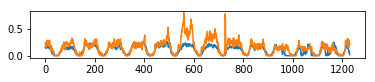

Train Score: 0.0437 RMSE
Test Score: 0.0702 RMSE
Train Score: 80.4465 MAPE
Test Score: 62.0603 MAPE


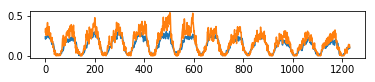

Train Score: 0.0653 RMSE
Test Score: 0.0553 RMSE
Train Score: 31.8583 MAPE
Test Score: 34.4956 MAPE


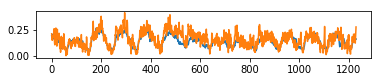

Train Score: 0.0643 RMSE
Test Score: 0.0606 RMSE
Train Score: 51.2922 MAPE
Test Score: 62.9327 MAPE


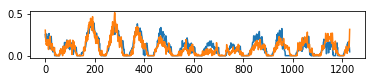

In [71]:
# blue is actual, orange is predicted
plt.subplot(411)
verify_plot_multi(trainPredict21, testPredict21, trainY21, testY21, 1)
plt.subplot(412)
verify_plot_multi(trainPredict21, testPredict21, trainY21, testY21, 2)
plt.subplot(413)
verify_plot_multi(trainPredict21, testPredict21, trainY21, testY21, 3)
plt.subplot(414)
verify_plot_multi(trainPredict21, testPredict21, trainY21, testY21, 4)

### To test prediction at different timestamps, simply change the parameter ‘start’ and ‘num_time’ and make sure that the sum of ‘start’ and ‘num_time’ equals to the start of the prediction timestamp 
### The ‘start’ parameter gives the model the freedom to train from any starting point of the data. ‘start’ can also help identify at which time period the demand shows unusual or anomaly patterns

### Some other thoughts which is not implemented finally include DBSCAN or ConvLSTM for spatial dependency

### Disadvantage in this approach: have to rerun the model to predict for different future timestamps, etc...


'''coords = df28.as_matrix(columns = ['lat','lon'])
km_per_radian = 6371.0088
epsilon = 2.5 / km_per_radian
db = DBSCAN(eps=epsilon,min_samples=1,algorithm='ball_tree',metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print(num_clusters)
[len(clusters[i]) for i in range(num_clusters)]'''
num cluster may vary for different dataset

In [73]:
# save and load model
outdir = 'C://Users/ubczh/Downloads/traffic-management/Traffic Management/'
model11_1.save(outdir +'try_model11_1.h5')
keras.models.load_model(outdir+'try_model11_1.h5')